<a href="https://colab.research.google.com/github/marcelcastrobr/notebooks/blob/master/_notebooks/Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation
First we need to install sentence-transformers

In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 3.1 MB 11.3 MB/s 
     |████████████████████████████████| 3.3 MB 28.9 MB/s 
     |████████████████████████████████| 1.2 MB 34.2 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
     |████████████████████████████████| 895 kB 38.8 MB/s 
     |████████████████████████████████| 596 kB 42.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=f7a209998618704c344dad092c6593fe0ad32927fe12546dab31670c8027aaaa
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Load CLIP Model
Next we load the CLIP model using SentenceTransformer. The model is downloaded automatically.

In [2]:
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [3]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

In [4]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('unsplash/photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

  0%|          | 0.00/51.8M [00:00<?, ?B/s]

Images: 24996


In [5]:
# Next, we define a search function.
def search(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=200))

Query:


'Two cats playing on the street'

4mA9_5vbZ_s.jpg


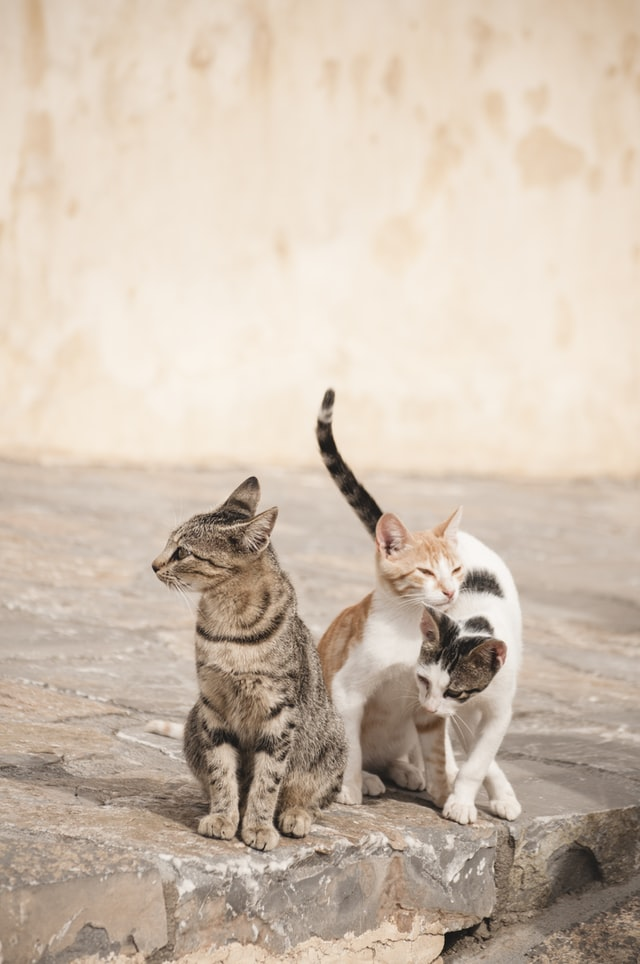

w6tMRf7kGLA.jpg


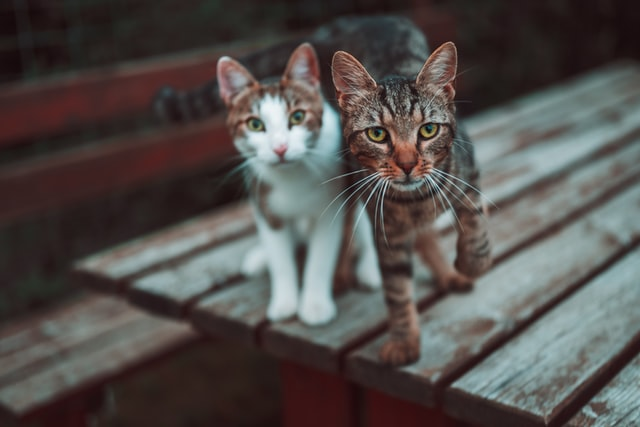

n4pNuXxyIr4.jpg


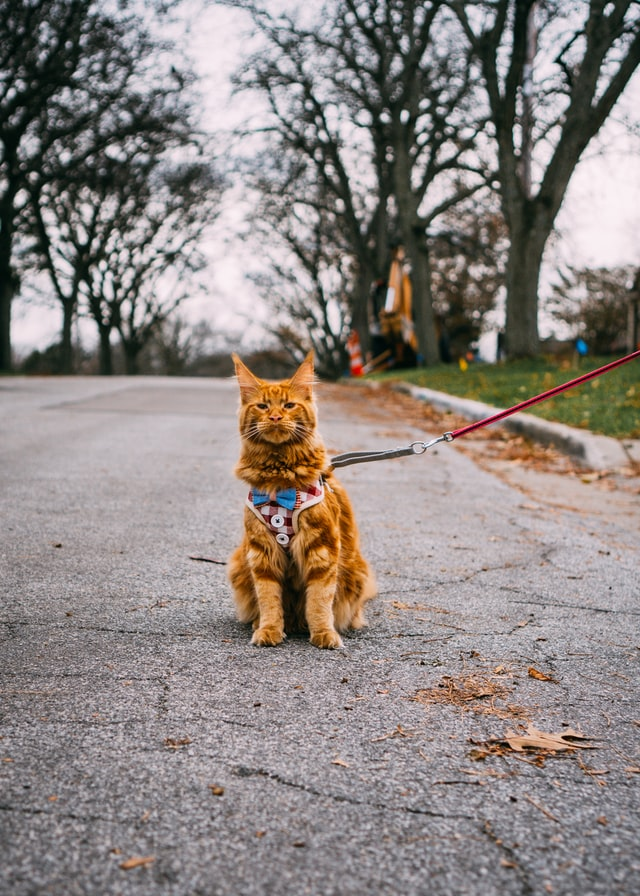

In [9]:
search("Two cats playing on the street")

Query:


'A sunset on the montain'

Zf4jpcGEinM.jpg


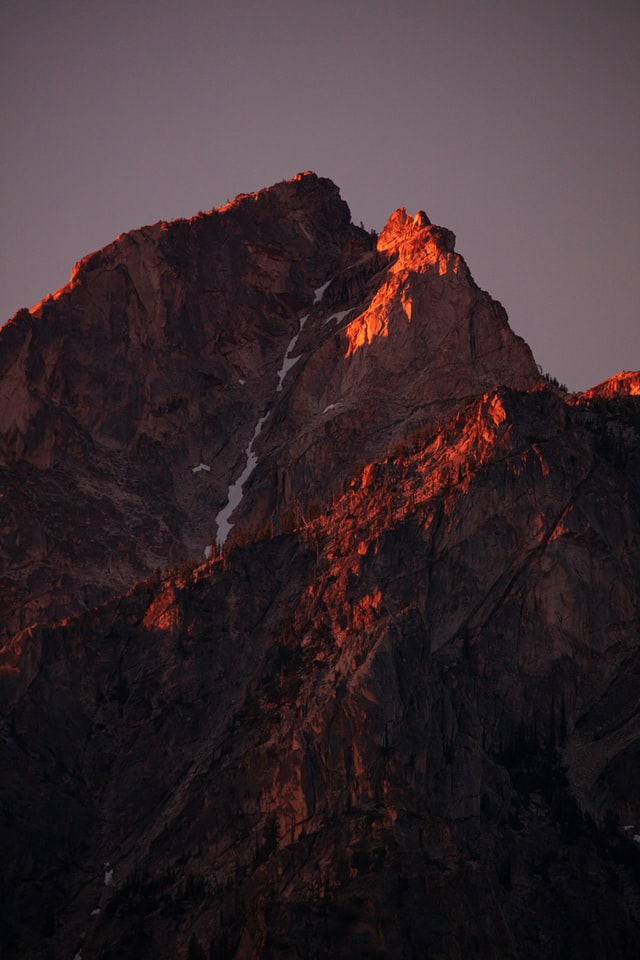

G5JDRSKi3uY.jpg


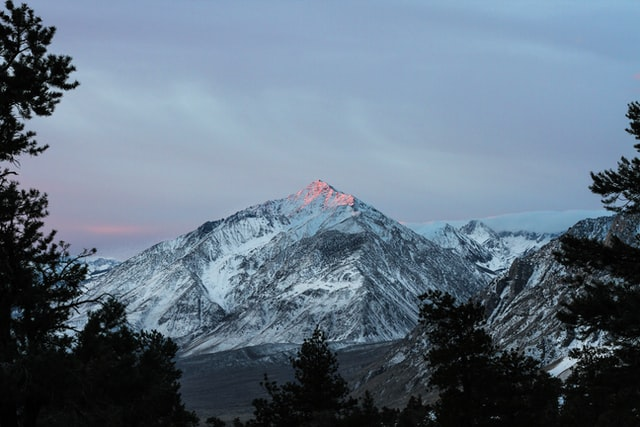

ig9yVlj5YYg.jpg


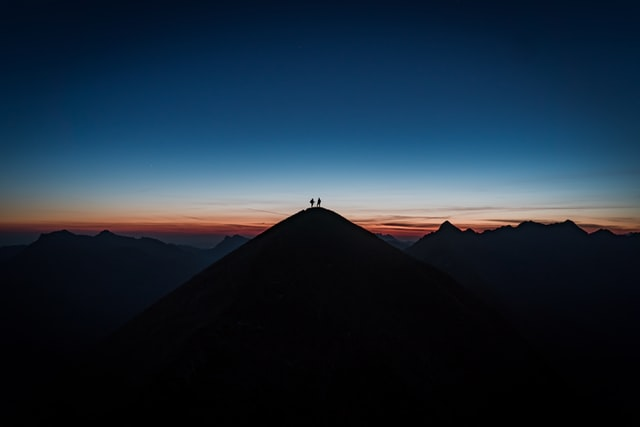

In [7]:
search("A sunset on the montain")

Query:


'Oslo'

uHsQou9tWTQ.jpg


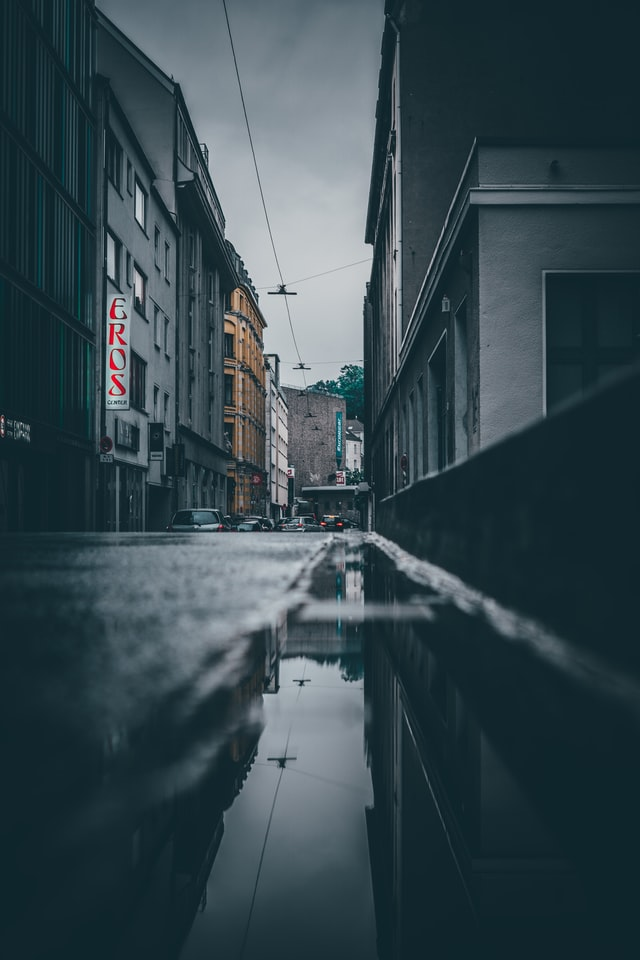

0ABCZ9bTsw4.jpg


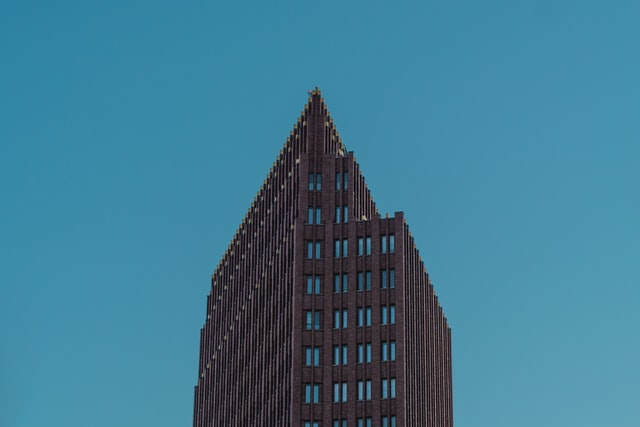

d5_hjWQ4NwA.jpg


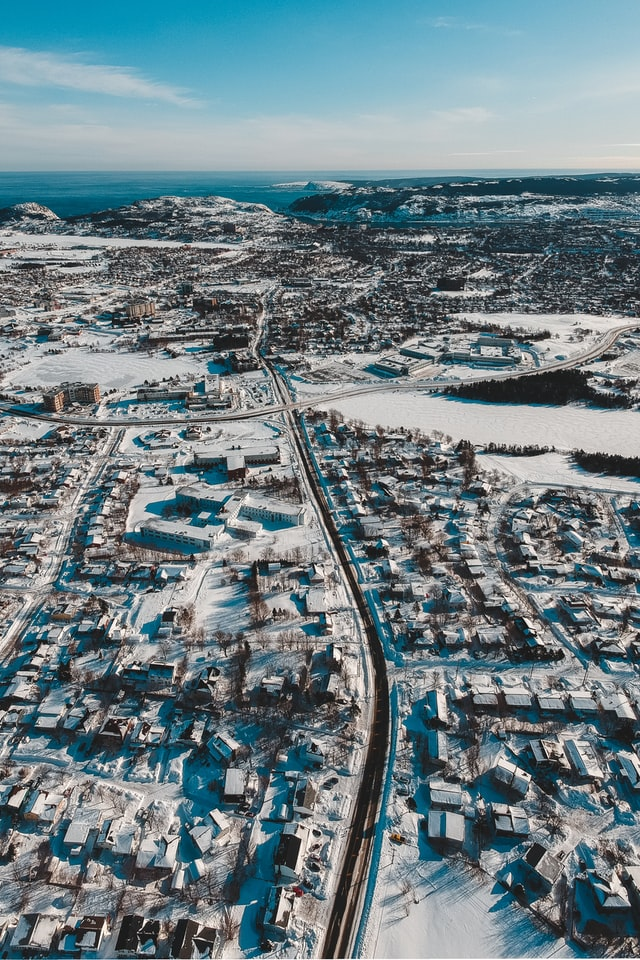

In [10]:
search("Oslo")

Query:


'A dog in a park'

IVyZrLp41D0.jpg


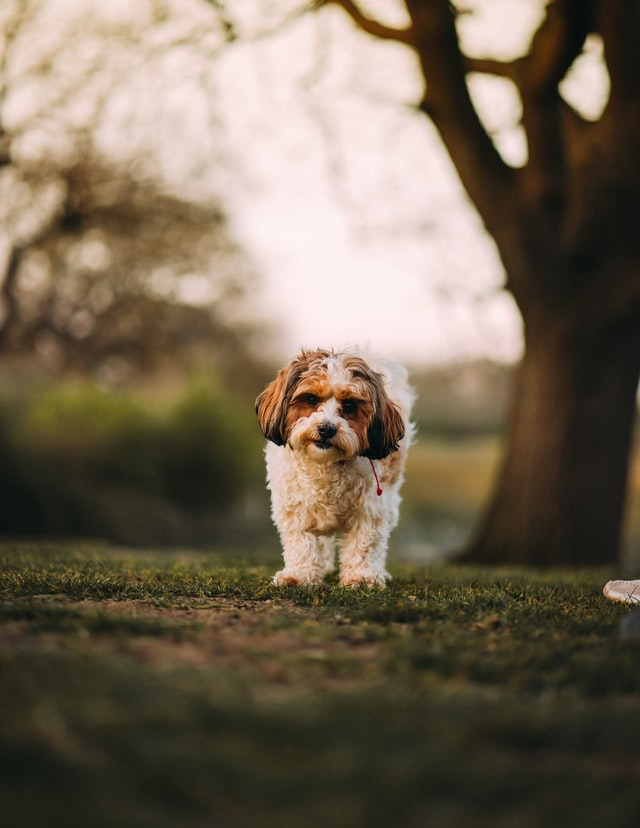

0O9A0F_d1qA.jpg


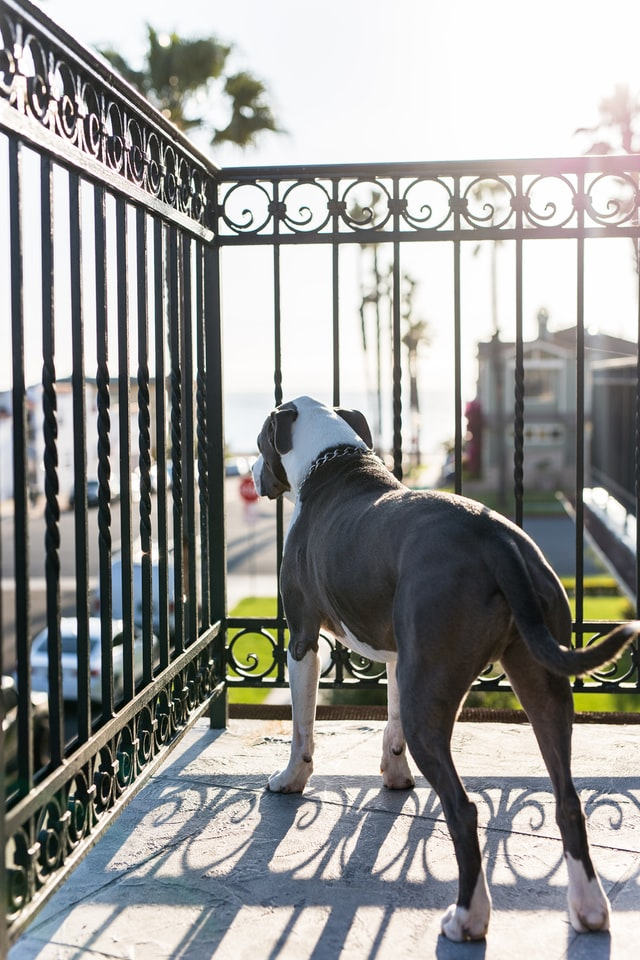

KVeogBZzl4M.jpg


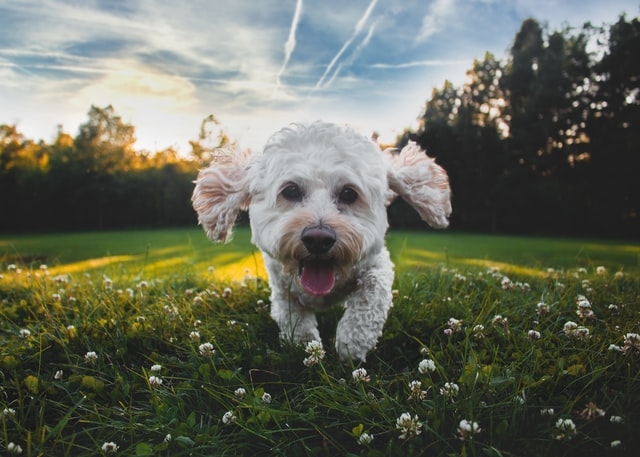

In [ ]:
search("A dog in a park")

Query:


'A beach with palm trees'

7rrgPPljqYU.jpg


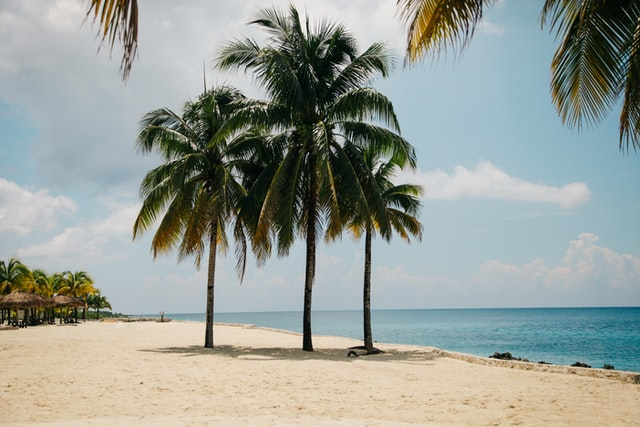

kmihWgpbDEg.jpg


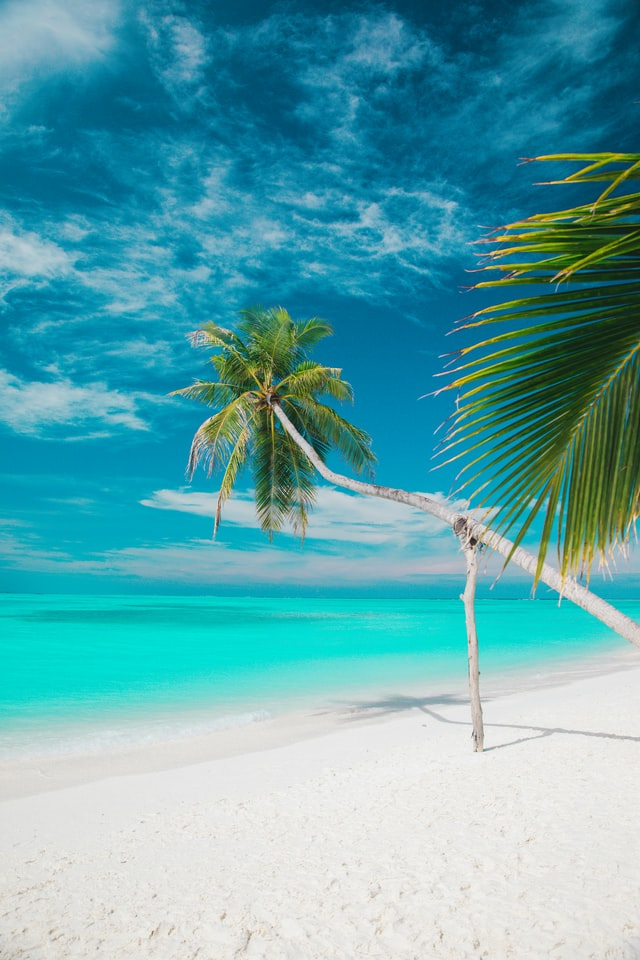

ZyfOq52b0cs.jpg


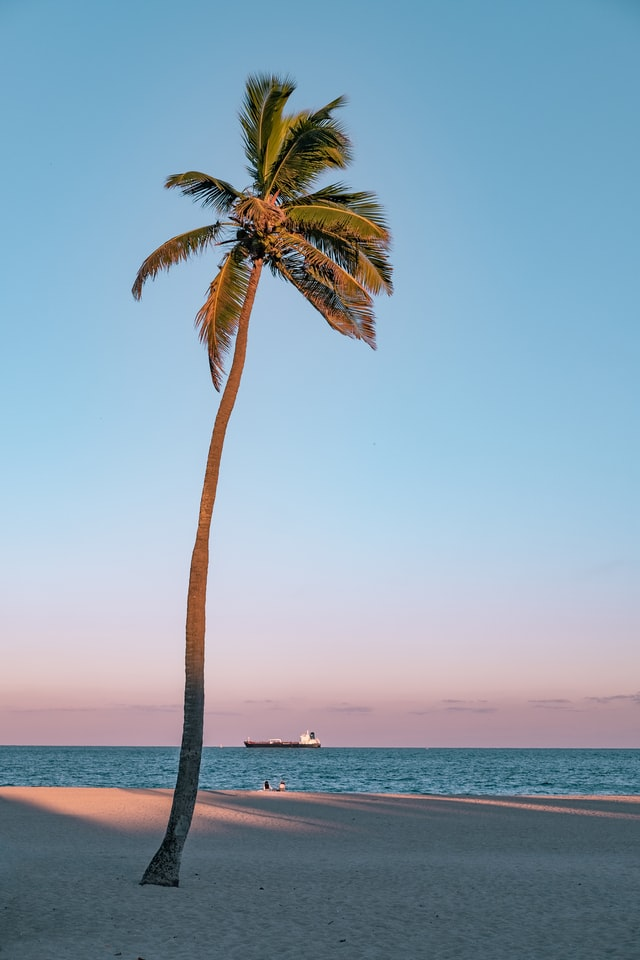

In [ ]:
search("A beach with palm trees")

# Image-to-Image Search
You can use the method also for image-to-image search.

To achieve this, you pass `Image.open('path/to/image.jpg')` to the search method.

It will then return similar images

Query:


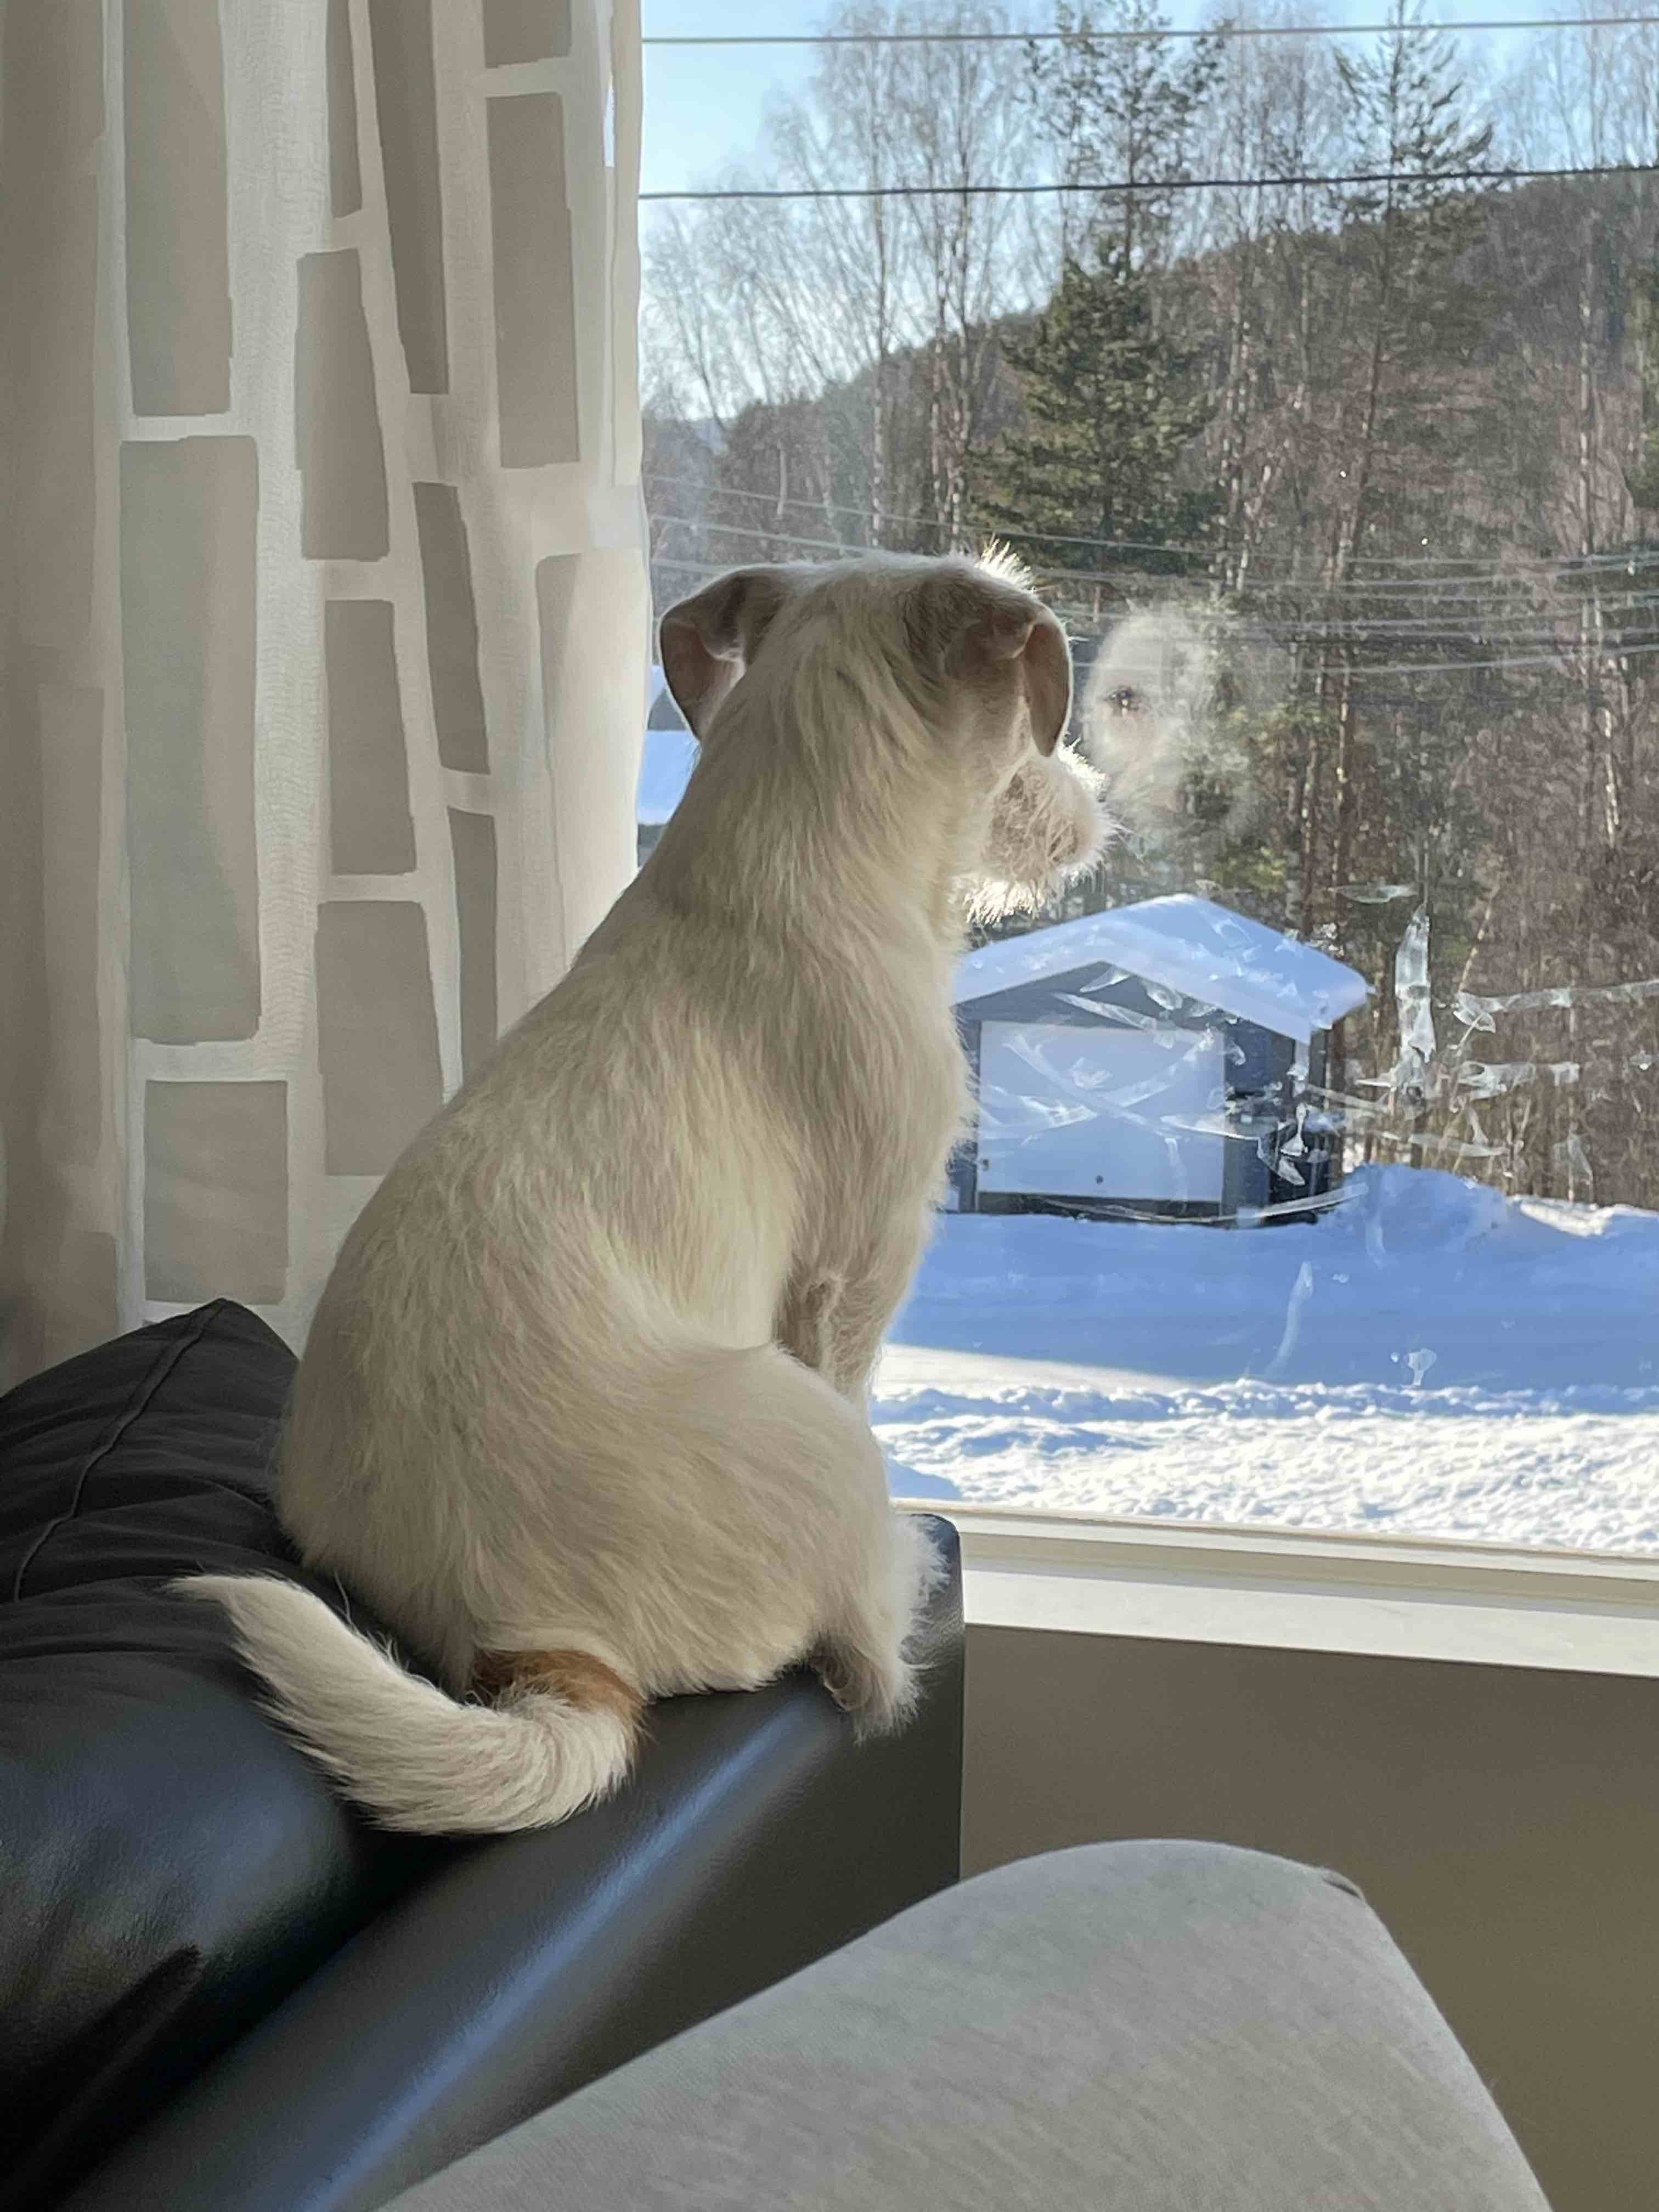

mgOXIPnyIxg.jpg


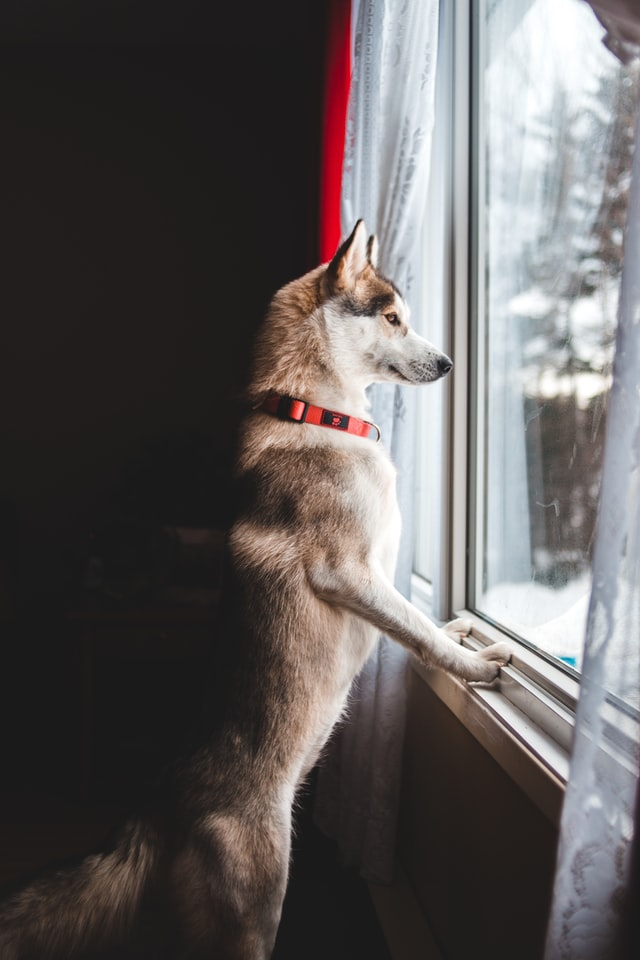

L8PkoOGLMSk.jpg


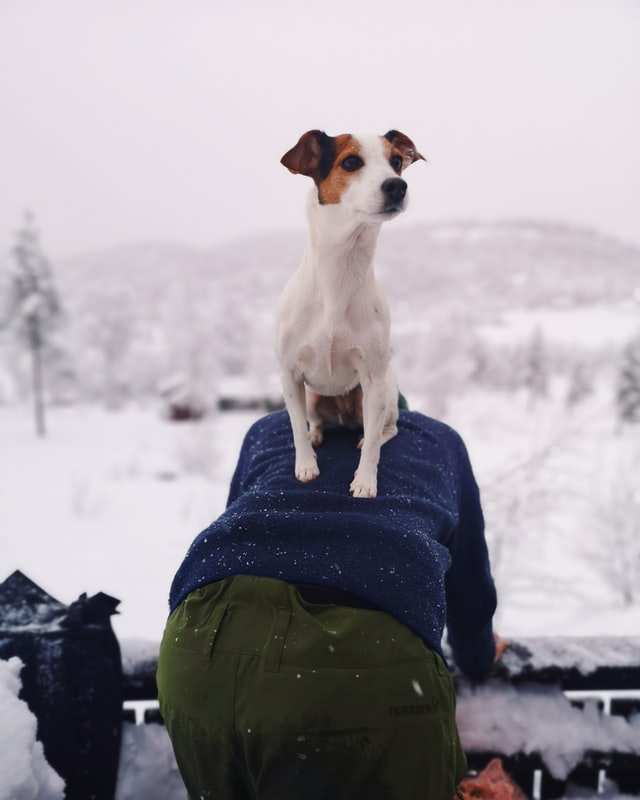

0T3R-QVgXUg.jpg


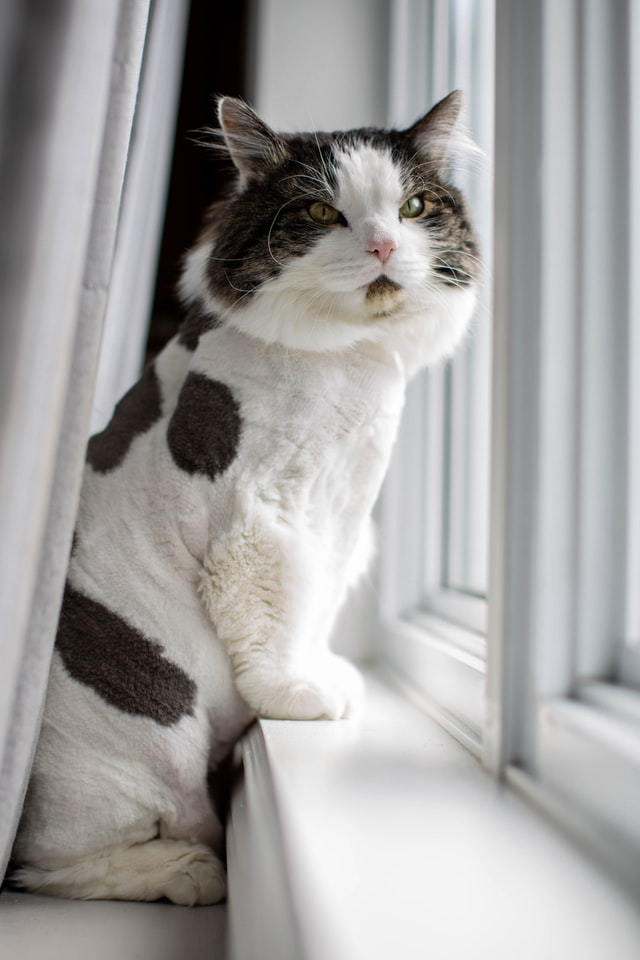

JqwRXYpSMDY.jpg


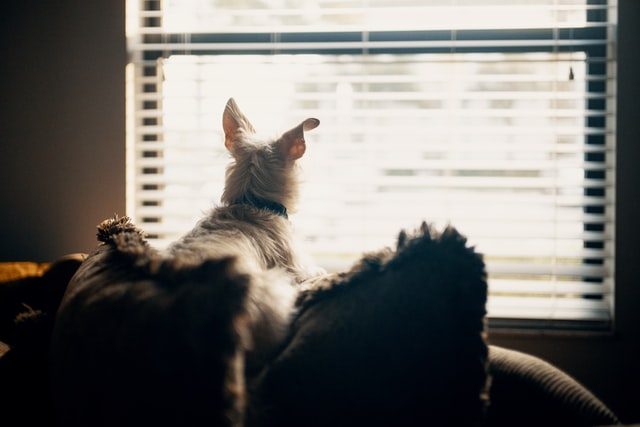

gcE6vwqOBjY.jpg


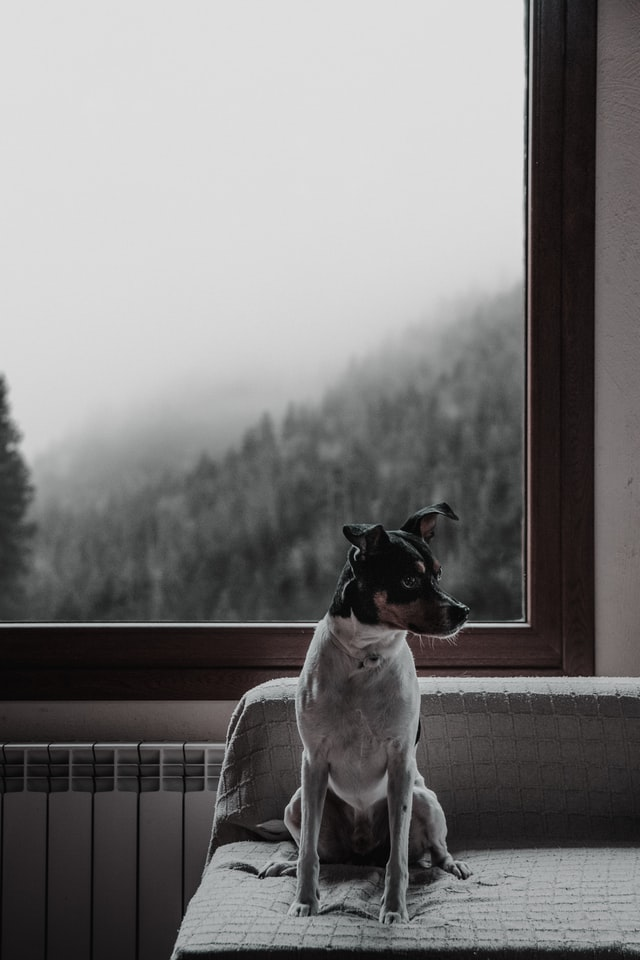

In [17]:
img_test_folder = 'test/'
search(Image.open(os.path.join(img_test_folder, 'branca.jpg')), k=5)